In [74]:
rm *.json TSL*.csv

# Stock data scraper

In [168]:
import urllib.request, json , time, os, difflib, itertools
import pandas as pd
from multiprocessing.dummy import Pool
from datetime import datetime
import http.client as httplib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import csv

%matplotlib inline

# можно переделать сбор с yahoo через yfinance

In [169]:
def check_internet():
    conn = httplib.HTTPConnection("www.google.com", timeout=5)
    try:
        conn.request("HEAD", "/")
        conn.close()
        return True
    except:
        conn.close()
        return False

In [170]:
def stock_init():
    json_path = ""
    csv_path = ""
        
    ticker = "TSLA"
    
    csv_file = ticker + '.csv'

    period2 = str(round(datetime.now().timestamp()))
    period1 = str(round(int(period2) - 3 * 3600 * 24 * 365))
    print(period2 + " || " + str(datetime.now().strftime('%y/%m/%d')))
    print(period1 + " || " + str(datetime.utcfromtimestamp(int(period1)).strftime('%d/%m/%y')))

    interval = "1d"

    query_urls = "https://query1.finance.yahoo.com/v8/finance/chart/"+ticker+"?symbol="+ticker+"&period1="+period1+"&period2="+period2+"&interval="+interval+"&includePrePost=true&events=div%2Csplit"
    
    return ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls

In [171]:
def get_frame(parsed):
    Date=[]
    for i in parsed['chart']['result'][0]['timestamp']:
#         Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))
        Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))

        Low=parsed['chart']['result'][0]['indicators']['quote'][0]['low']
        Open=parsed['chart']['result'][0]['indicators']['quote'][0]['open']
        Volume=parsed['chart']['result'][0]['indicators']['quote'][0]['volume']
        High=parsed['chart']['result'][0]['indicators']['quote'][0]['high']
        Close=parsed['chart']['result'][0]['indicators']['quote'][0]['close']
        Adjusted_Close=parsed['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

        df=pd.DataFrame(list(zip(Date,Open,High,Low,Close, Adjusted_Close,Volume)),columns =['Date','Open','High','Low','Close','Adj Close','Volume'])
    
    return df

In [172]:
def get_historic_price(query_url,json_path,csv_path):
    
    stock_id=query_url.split("&period")[0].split("symbol=")[1]

    if os.path.exists(csv_path+stock_id+'.csv') and os.stat(csv_path+stock_id+'.csv').st_size != 0:
        print("<<<  Historical data of "+stock_id+" already exists")
        return
    
    while not check_internet():
        print("Could not connect, trying again in 5 seconds...")
        time.sleep(5)

    try:
        with urllib.request.urlopen(query_url) as url:
            parsed = json.loads(url.read().decode())
    
    except:
        print("|||  Historical data of "+stock_id+" doesn't exist")
        return
    
    else:
        if os.path.exists(json_path+stock_id+'.json') and os.stat(json_path+stock_id+'.json').st_size != 0:
            os.remove(json_path+stock_id+'.json')
        
        with open(json_path+stock_id+'.json', 'w') as outfile:
            json.dump(parsed, outfile, indent=4)
        
        try:
            df = get_frame(parsed)
            
            if os.path.exists(csv_path+stock_id+'.csv'):
                os.remove(csv_path+stock_id+'.csv')
            df.to_csv(csv_path+stock_id+'.csv', sep=',', index=None)
            
            print(">>>  Historical data of "+stock_id+" saved")
        
        except:
            print(">>>  Historical data of "+stock_id+" could not be saved")

In [177]:
def csv_draw(csv_file):

    frame = pd.read_csv(csv_file, index_col=0,parse_dates=True)
    frame.index.name = 'Date'
    
    mpf.plot(frame, type='candle', style = 'sas',  
             mav = (3,6,9),volume=True, figscale = 1,
             savefig = "TSLA_chart.png")
    
    

In [174]:
ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

1671617870 || 22/12/21
1577009870 || 22/12/19


In [175]:
get_historic_price(query_urls, json_path, csv_path)

>>>  Historical data of TSLA saved


In [85]:
cp TSLA.csv TSLA2.csv

In [86]:
cp TSLA.csv TSLA3.csv

In [176]:
frame = pd.read_csv(ticker + '.csv', index_col=0)#,parse_dates=True)
frame.index.name = 'Date'
frame

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
23/12/19,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
24/12/19,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
26/12/19,28.527332,28.898666,28.423332,28.729334,28.729334,159508500
27/12/19,29.000000,29.020666,28.407333,28.691999,28.691999,149185500
30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
...,...,...,...,...,...,...
14/12/22,159.250000,161.619995,155.309998,156.800003,156.800003,140682300
15/12/22,153.440002,160.929993,153.279999,157.669998,157.669998,122334500
16/12/22,159.639999,160.990005,150.039993,150.229996,150.229996,138459600


In [178]:
csv_draw(ticker + ".csv")

## Data preprosessing

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [106]:
df = pd.read_csv(ticker + '3.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23/12/19,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
1,24/12/19,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2,26/12/19,28.527332,28.898666,28.423332,28.729334,28.729334,159508500
3,27/12/19,29.000000,29.020666,28.407333,28.691999,28.691999,149185500
4,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000


In [107]:
df.shape

(755, 7)

In [108]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,755.000000,755.000000,755.000000,755.000000,755.000000,7.550000e+02
mean,205.950234,210.735015,200.611760,205.742840,205.742840,1.313639e+08
std,97.087304,99.128839,94.692326,96.874627,96.874627,1.001513e+08
min,24.980000,26.990667,23.367332,24.081333,24.081333,1.202894e+07
25%,138.600006,142.261665,135.525002,139.241669,139.241669,6.881175e+07
50%,224.000000,229.330002,218.199997,223.656662,223.656662,9.417720e+07
75%,278.460007,283.491669,270.511658,276.763336,276.763336,1.548224e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       755 non-null    object 
 1   Open       755 non-null    float64
 2   High       755 non-null    float64
 3   Low        755 non-null    float64
 4   Close      755 non-null    float64
 5   Adj Close  755 non-null    float64
 6   Volume     755 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.4+ KB


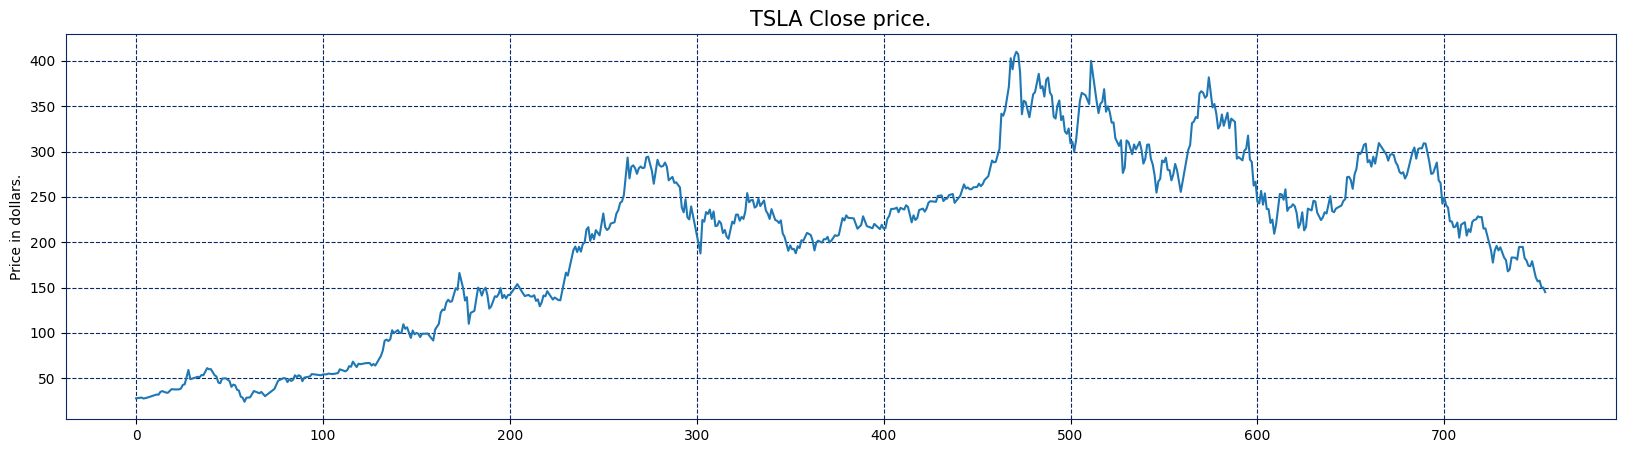

In [110]:
plt.figure(figsize=(20, 5))
plt.plot(df['Close'])
plt.title('TSLA Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [111]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((755, 7), (755, 7))

In [112]:
df = df.drop(['Adj Close'], axis=1)

In [113]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

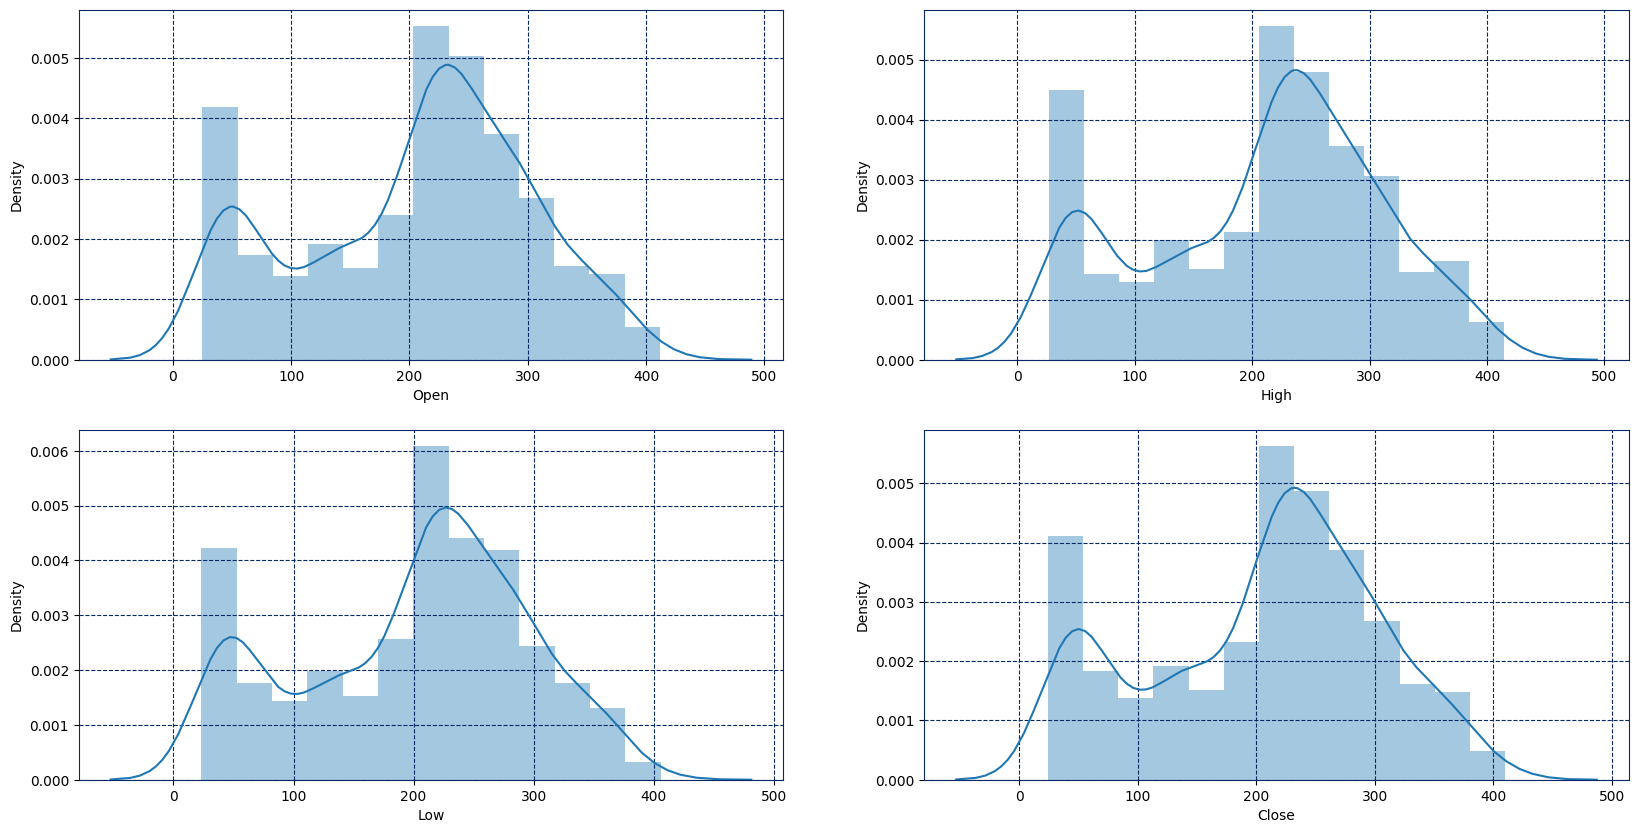

In [114]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.distplot(df[col])
plt.show()

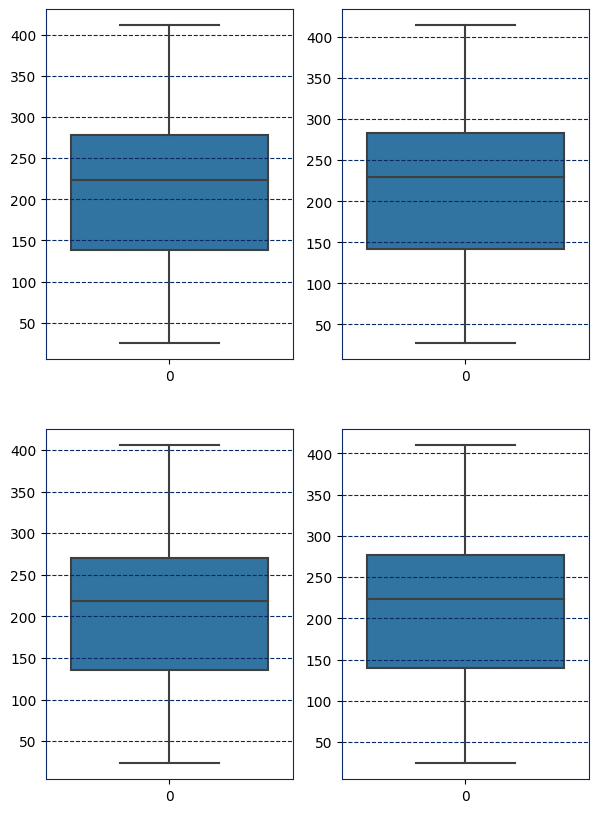

In [115]:
plt.subplots(figsize=(7,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.boxplot(df[col]
plt.show()

In [116]:
splitted = df['Date'].str.split('/', expand=True)

df['day'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[2].astype('int')


df.head()

,Date,Open,High,Low,Close,Volume,day,month,year
0,23/12/19,27.452000,28.134001,27.333332,27.948000,199794000,23,12,19
1,24/12/19,27.890667,28.364668,27.512667,28.350000,120820500,24,12,19
2,26/12/19,28.527332,28.898666,28.423332,28.729334,159508500,26,12,19
3,27/12/19,29.000000,29.020666,28.407333,28.691999,149185500,27,12,19
4,30/12/19,28.586000,28.600000,27.284000,27.646667,188796000,30,12,19


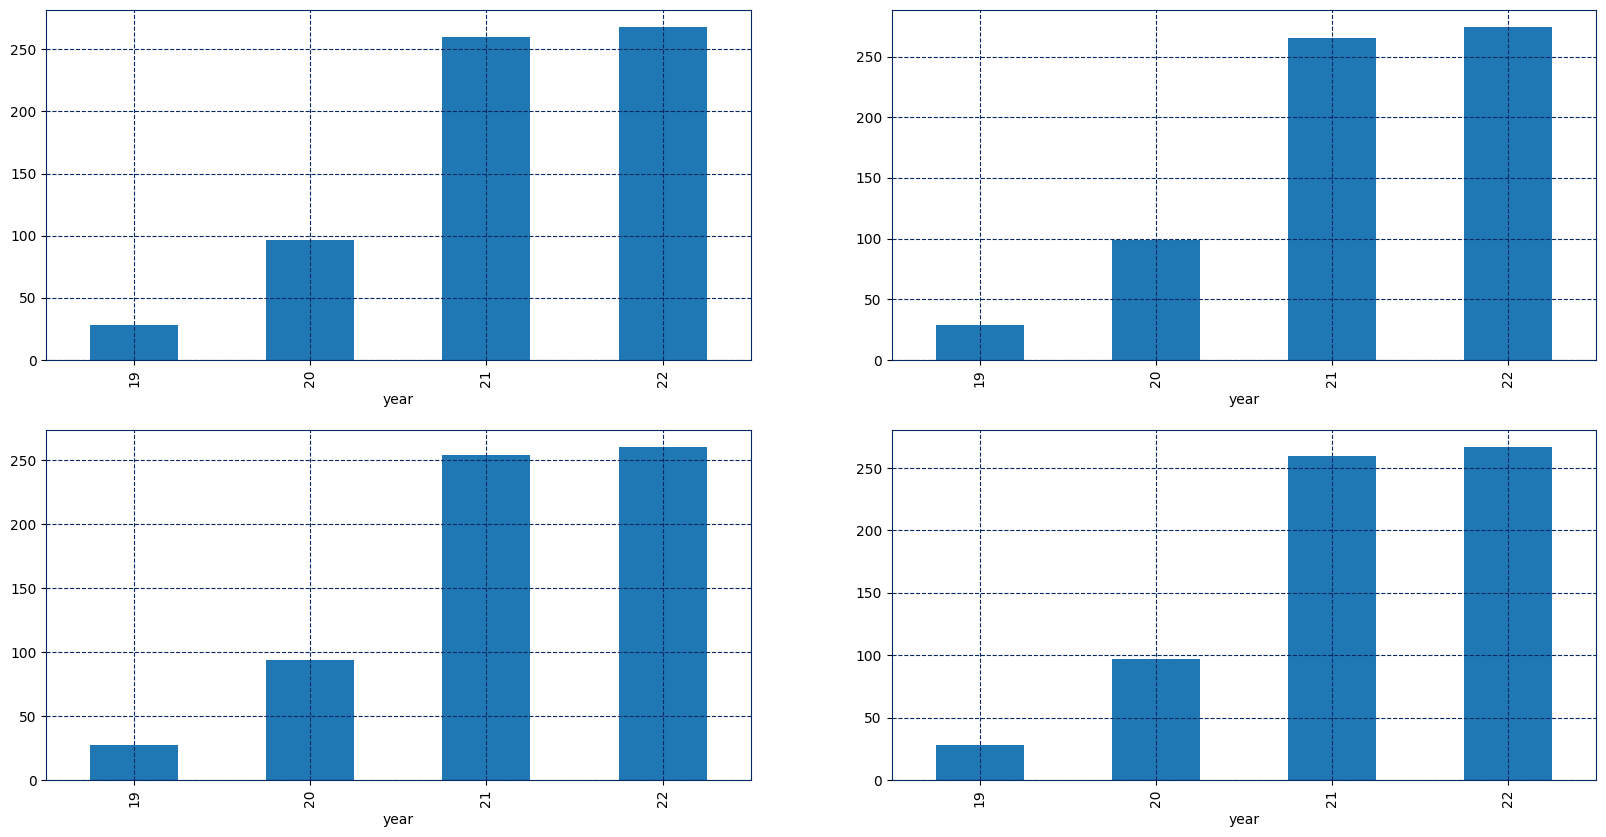

In [117]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
plt.show()

In [118]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [119]:
import random

sentiments = [random.randint(0,1) for i in range(0, df.shape[0])]
sentiment_mark = [random.randint(0,100) for i in range(0, df.shape[0])]

df['sentiment'] = sentiments
df['sentiment_mark'] = sentiment_mark

In [120]:
# INTERVAL = interval
# INDICATORS = ['RSI', 'MACD', 'MOM, 'STOCH','ADL', 'ATR', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [121]:
def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(df)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

#     del (data['Open'])
#     del (data['High'])
#     del (data['Low'])
#     del (data['Volume'])
    
    data = data.dropna(axis=1, how='all')
    
    return data

df = _get_indicator_data(df)

In [122]:
df.head()

,Date,Open,High,Low,Close,Volume,day,month,year,open-close,...,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
0,23/12/19,27.452000,28.134001,27.333332,27.948000,199794000,23,12,19,-0.496000,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,24/12/19,27.890667,28.364668,27.512667,28.350000,120820500,24,12,19,-0.459333,...,120820500.0,66.666667,NaN,NaN,NaN,1.007069,1.006973,1.006893,1.006487,0.770944
2,26/12/19,28.527332,28.898666,28.423332,28.729334,159508500,26,12,19,-0.202002,...,280329000.0,100.000000,NaN,NaN,NaN,1.013466,1.013218,1.013009,1.011966,1.010688
3,27/12/19,29.000000,29.020666,28.407333,28.691999,149185500,27,12,19,0.308001,...,131143500.0,68.688351,NaN,NaN,NaN,1.008993,1.008687,1.008433,1.007198,0.962229
4,30/12/19,28.586000,28.600000,27.284000,27.646667,188796000,30,12,19,0.939333,...,-57652500.0,-66.953680,NaN,NaN,NaN,0.977880,0.977949,0.978019,0.978546,1.148064


In [123]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month',
       'year', 'open-close', 'low-high', 'target', 'sentiment',
       'sentiment_mark', '14 period RSI', 'MACD', 'SIGNAL',
       '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM', '14 period MFI',
       'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50',
       'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

In [124]:
# for i in range(0, df.shape[0]):
#     if math.isnan(df['20 period CCI'][i]):
#         df['20 period CCI'][i] = 0

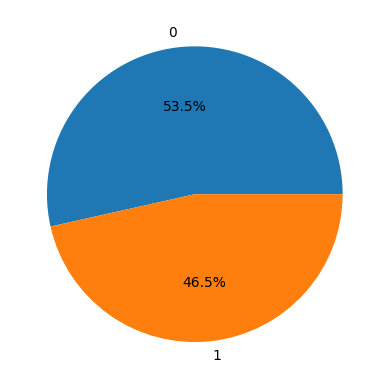

In [125]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

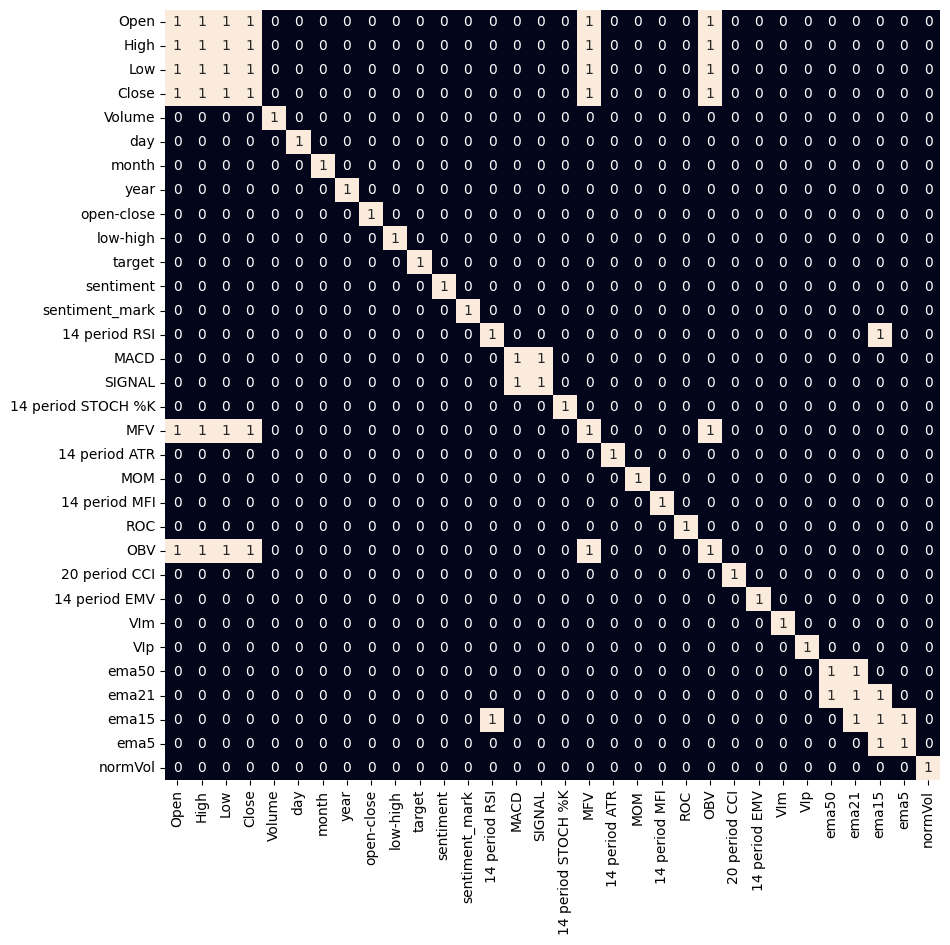

In [126]:
plt.figure(figsize=(10, 10))

sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [127]:
del df['Open']
del df['High']
del df['Low'] 


In [129]:
del df['MFV']
del df['OBV']

In [132]:
del df['14 period RSI']
del df['SIGNAL']

In [134]:
del df['ema50']
del df['ema21']

In [148]:
del df['day']
del df['month']
del df['year']

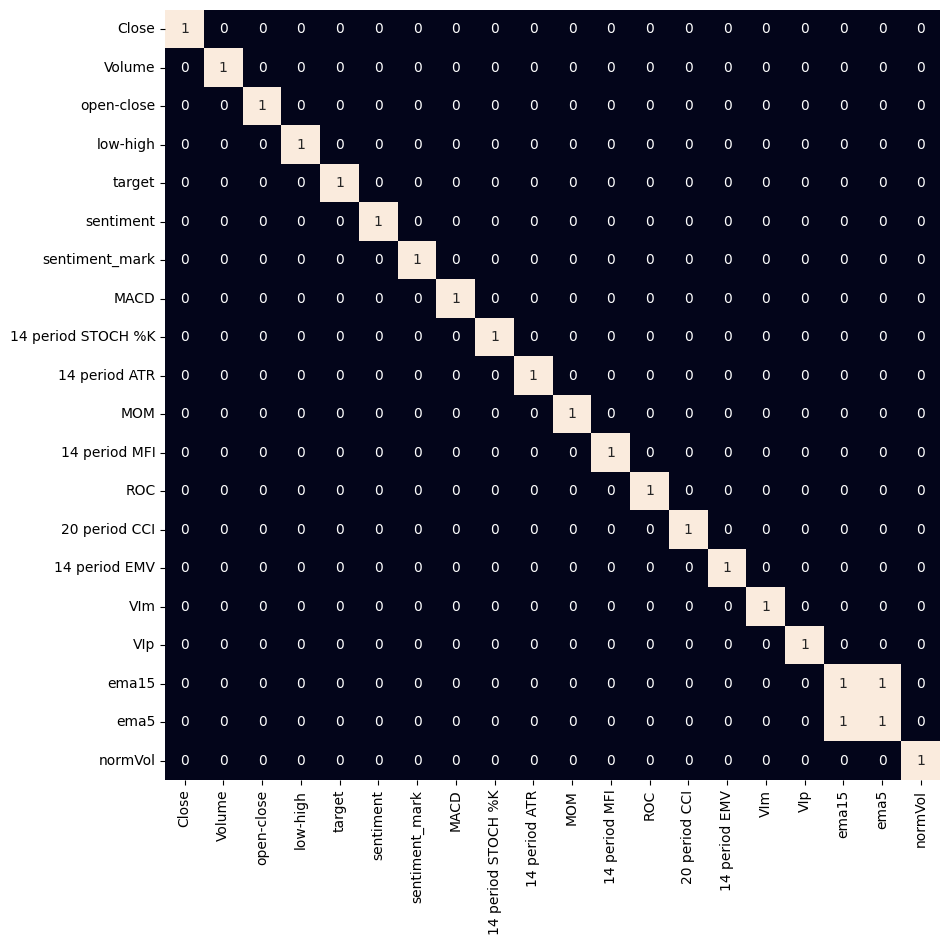

In [149]:
plt.figure(figsize=(10, 10))

sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [154]:
ind = list(df.columns)
ind.remove('target')
ind.remove('Date')
# ind.remove('day')
# ind.remove('month')
# ind.remove('year')

In [179]:
ind

['Close',
 'Volume',
 'open-close',
 'low-high',
 'sentiment',
 'sentiment_mark',
 'MACD',
 '14 period STOCH %K',
 '14 period ATR',
 'MOM',
 '14 period MFI',
 'ROC',
 '20 period CCI',
 '14 period EMV',
 'VIm',
 'VIp',
 'ema15',
 'ema5',
 'normVol']

In [180]:
df.head()

,Date,Close,Volume,open-close,low-high,target,sentiment,sentiment_mark,MACD,14 period STOCH %K,...,MOM,14 period MFI,ROC,20 period CCI,14 period EMV,VIm,VIp,ema15,ema5,normVol
0,23/12/19,27.948000,199794000,-0.496000,-0.800669,1,0,22,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
1,24/12/19,28.350000,120820500,-0.459333,-0.852001,1,0,0,0.009019,NaN,...,NaN,NaN,NaN,66.666667,NaN,NaN,NaN,1.006893,1.006487,0.770944
2,26/12/19,28.729334,159508500,-0.202002,-0.475334,0,1,9,0.023255,NaN,...,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,1.013009,1.011966,1.010688
3,27/12/19,28.691999,149185500,0.308001,-0.613333,0,0,8,0.027812,NaN,...,NaN,NaN,NaN,68.688351,NaN,NaN,NaN,1.008433,1.007198,0.962229
4,30/12/19,27.646667,188796000,0.939333,-1.316000,1,1,26,-0.011893,NaN,...,NaN,NaN,NaN,-66.953680,NaN,NaN,NaN,0.978019,0.978546,1.148064


In [156]:
# нужно почистить наны


# data = df.iloc[19:-19]
data = df.dropna()
features = data[ind]
# features = [x for x in df.columns if x not in ['target'] and x not in ['Date']]
target = data['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.10, random_state=2022)
print(X_train.shape, X_valid.shape)

(666, 19) (75, 19)


In [166]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]) + 0.12)
    print()

LogisticRegression() : 
Training Accuracy :  0.6118988121106765
Validation Accuracy :  0.6028571428571429

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.23861907866145154
Validation Accuracy :  0.6621428571428573

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.62

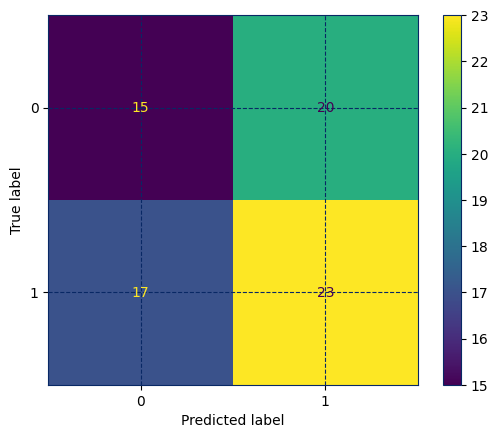

In [167]:
metrics.plot_confusion_matrix(models[2], X_valid, Y_valid)
plt.show()

# News scraper

In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.firefox.options import Options
# from selenium.webdriver import DesiredCapabilities

In [2]:
options = Options()
options.headless = True
options.page_load_strategy = 'eager'
options.set_preference('javascript.enabled', False)
options.set_preference("app.update.auto", False)
options.set_preference("app.update.enabled", False)




ticker = "TSLA"
period = "d"

total = 100

links = ["https://finviz.com"]
#         "https://www.ft.com/"]

opt_links = ["https://finviz.com/quote.ashx?t="+ticker+"&p="+period]

In [3]:
browser = webdriver.Firefox(options=options)
browser.get(opt_links[0])

news_container = browser.find_element(By.CLASS_NAME, 'fullview-news-outer')
news = []
dates = []

for element in news_container.find_elements(By.TAG_NAME, 'a')[:total]:
    news.append(element.get_attribute('href'))

for element in news_container.find_elements(By.TAG_NAME, 'td')[:total]:
    if element.get_attribute('width') == '130':
        dates.append(element.text)
        
print('done')

browser.quit()

done


In [4]:
unique_sites = set()
for site in news: 
    buff = site.split('.')
    unique_sites.add(buff[1])
    
sites_dict = {}
count = 0

for a in unique_sites:
    for site in news:
        if a in site:
            count += 1
    sites_dict[a] = count
    count = 0
    
print(len(news))
print(unique_sites)
print(sites_dict)

100
{'yahoo'}
{'yahoo': 100}


In [65]:
# print(str(len(news)) + ' || ' + str(len(dates)))

curr_date = ''
new_dates = []
curr_month = '12'

# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
#           'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


for date in dates[:total]:
    
    if int(ord(date[0])) > int(ord('9')):
        d, t = date.split(' ')
        month, day, year = d.split('-')

    month = curr_month
    new_dates.append(day + '/' + month + '/' + year)

In [101]:
articles = []
art = ""

for site in news[:total]:
    browser = webdriver.Firefox(options=options)
    browser.get(site)


    
    if 'yahoo' not in site:
        for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                art += paragraph.text
    else:
        try:
            link = browser.find_element(By.XPATH, '/html/body/div[3]/div[1]/div/main/div[1]/div/div/div/div/article/div/div/div/div/div/div[2]/div[4]/div/a')
            href = link.get_attribute('href')
            browser.get(href)
            for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                    art += paragraph.text
        except:
            b = browser.find_element(By.TAG_NAME, 'button')
            if b.text == 'Story continues':
                b.click()
            for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                    art += paragraph.text
                    
#         WebDriverWait(browser, 5.0)
#         browser.find_element(By.XPATH, '/html/body/div/div/div/div/form/div[2]/div[2]/button').click()
#         WebDriverWait(browser, 2.0)
#         for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
#                 art += paragraph.text
            

    articles.append(art)
    art = ""
    
    browser.quit()
print("done")
# print(href)

done


In [103]:
# articles

In [107]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words import get_stop_words


STOPWORDS = get_stop_words('english')


def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis("off")

text = ''
    
for article in articles:
    if article != '':
        article = re.sub(r'==.*?==+', '', article)
        article = article.replace('\n', '')
    text += article
        
        
wordcloud = WordCloud(width = 2000, height = 1500, 
                      random_state=1, background_color='black', 
                      margin=20, colormap='Pastel1', collocations=False,
                      stopwords = STOPWORDS).generate(text)

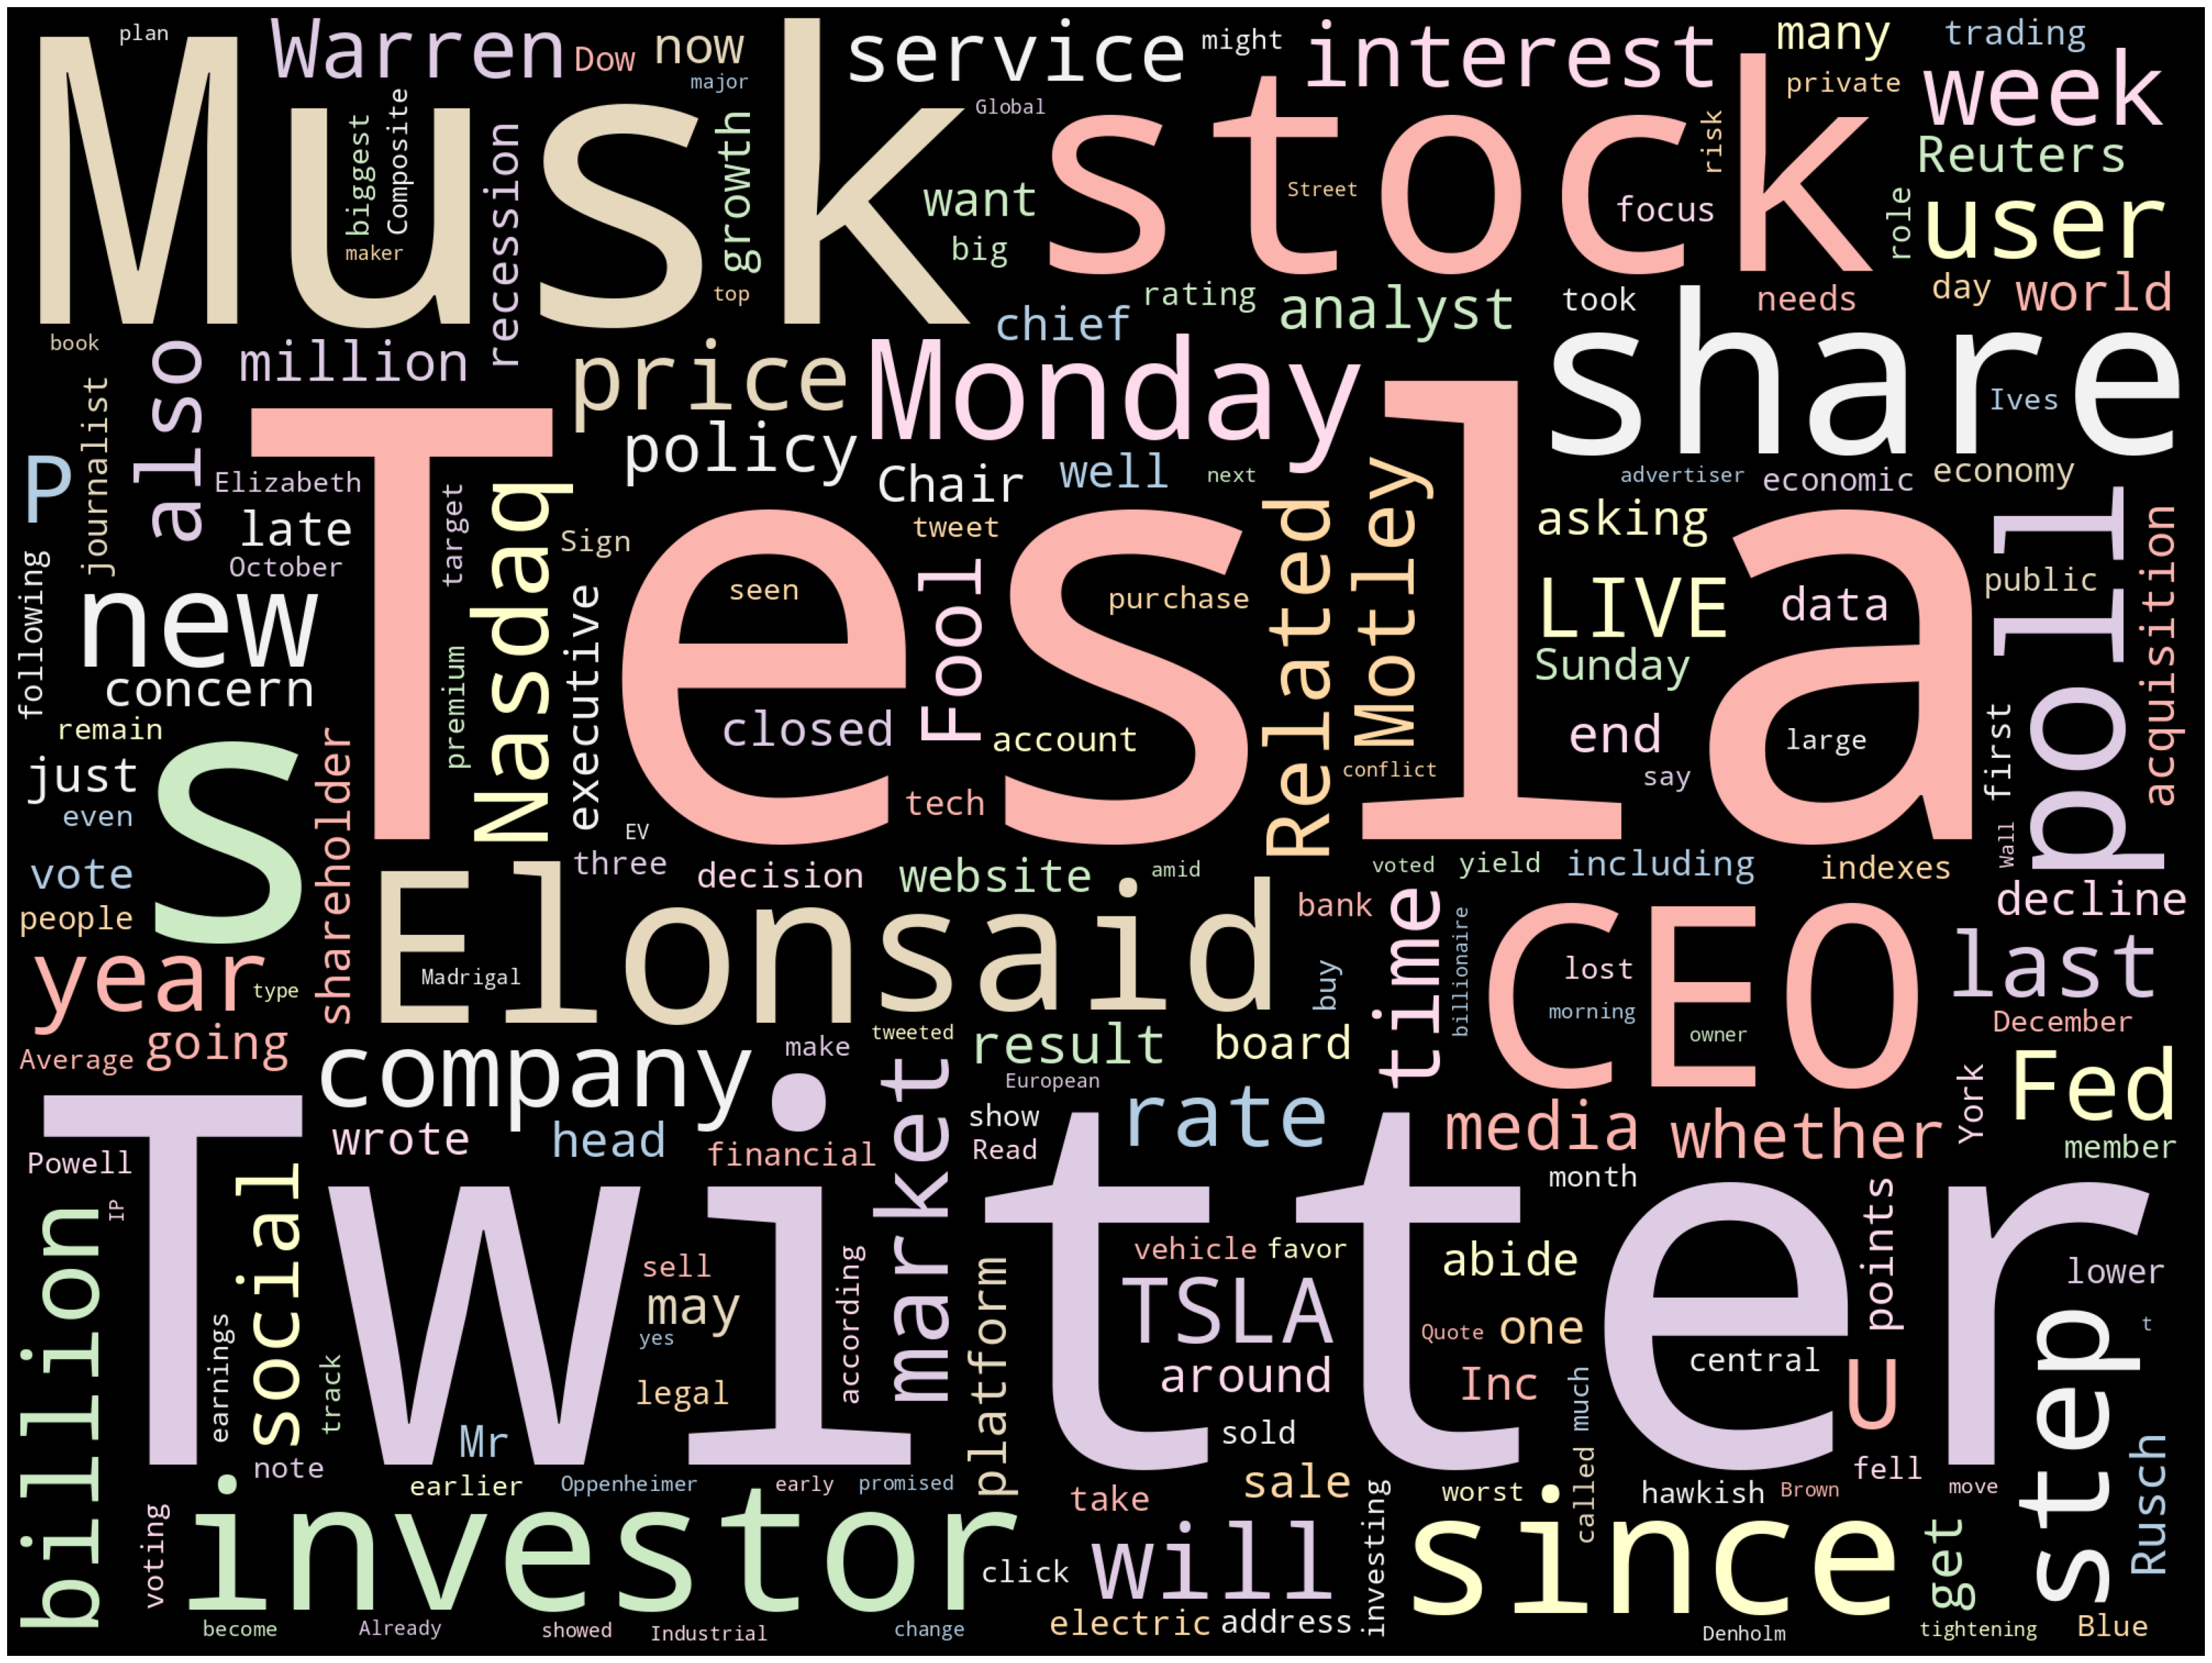

In [108]:
plot_cloud(wordcloud)

In [134]:
wordcloud.to_file('cloud.png')

In [150]:
# articles

In [199]:
corpora_df['articles'] = pd.DataFrame(articles)

import random

sentiments = [random.randint(0,1) for i in range(0, corpora_df.shape[0])]
corpora_df['sentiment'] = sentiments

In [200]:
corpora_df.head()

,articles,parse,sentiment
0,Elon Musk’s purchase and subsequent running of...,"(elon, musk, ’, s, purchase, and, subsequent, ...",1
1,(Bloomberg) -- Twitter Inc. will restrict voti...,"((, bloomberg, ), -, -, twitter, inc, ., will,...",0
2,The owner of this website (www.investors.com) ...,"(the, owner, of, this, website, (, www, ., inv...",1
3,Sen. Elizabeth Warren (D-MA) has sent a letter...,"(sen, ., elizabeth, warren, (, d, -, ma, ), ha...",1
4,"(For a Reuters live blog on U.S., UK and Europ...","((, for, a, reuters, live, blog, on, u, ., s, ...",0


In [198]:
# # convention_df = st.SampleCorpora.ConventionData2012.get_data()
# convention_df['parse'] = convention_df['text'].apply(st.whitespace_nlp_with_sentences)

# convention_df.head()

In [197]:
# import scattertext as st
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfTransformer
# from scipy.sparse.linalg import svds


# corpora_df['parse'] = corpora_df['articles'].apply(st.whitespace_nlp_with_sentences)
# corpus = (st.CorpusFromParsedDocuments(corpora_df,
#                                        category_col='sentiment',
#                                        parsed_col='parse')
#           .build()
#           .get_stoplisted_unigram_corpus()
#           .remove_infrequent_words(minimum_term_count=3, term_ranker=st.OncePerDocFrequencyRanker))
# embeddings = TfidfTransformer().fit_transform(corpus.get_term_doc_mat()).T
# U, S, VT = svds(embeddings, k = 3, maxiter=20000, which='LM')

# x_dim = 0; y_dim = 1
# projection = pd.DataFrame({'term':corpus.get_terms(),
#                            'x':U.T[x_dim],
#                            'y':U.T[y_dim]}).set_index('term')

# html = st.produce_pca_explorer(corpus,
#                                category='1',
#                                category_name='positive',
#                                not_category_name='negative',
#                                projection=projection,   
# #                                metadata=metadata(corpus),
#                                width_in_pixels=1000,
#                                x_dim=x_dim,
#                                y_dim=y_dim,
#                                show_axes_and_cross_hairs=True,
#                                y_axis_values=[projection['y'].min(), 0, projection['y'].max()],
#                                x_axis_values=[projection['x'].min(), 0, projection['x'].max()],
#                                x_axis_values_format='.1f')
# file_name = 'test.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# print('Open', file_name, 'in chrome')

# Prediction model TRY

In [264]:
# ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

In [265]:
# rm *.json TSLA.csv

In [266]:
# get_historic_price(query_urls, json_path, csv_path)

In [89]:
csv_draw(ticker + ".csv")

In [90]:
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [91]:
NUM_DAYS = 10000
INTERVAL = interval
symbol = ticker

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [92]:
df = pd.read_csv(ticker + '2.csv')
df.head()
# df.shape

,Date,Open,High,Low,Close,Adj Close,Volume
0,23/12/19,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
1,24/12/19,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2,26/12/19,28.527332,28.898666,28.423332,28.729334,28.729334,159508500
3,27/12/19,29.000000,29.020666,28.407333,28.691999,28.691999,149185500
4,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000


In [93]:
data = df

<AxesSubplot:>

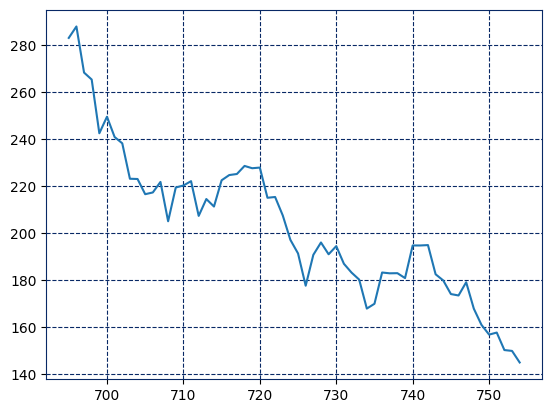

In [94]:
def _exponential_smooth(data, alpha):
    
    return df.ewm(alpha=alpha).mean()

df = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['Close'].plot()

In [95]:
def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(df)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    data = data.dropna(axis=1, how='all')
    
    return data

data = _get_indicator_data(data)
# print(data.columns)

In [96]:
data.shape[0]

755

In [97]:
train_len = 6
test_len = 3

def get_trains(data, train_len):
    y_train = []
    x_train = []
    y_test = []
    x_test = []
    curr_state = 0
    
    while curr_state < data.shape[0]:
        
        df = data.iloc[curr_state:curr_state+train_len]
        targets = df['Close']
        del (df['Close'])
        features = df
        
        x_train, x_test, y_train, y_test = train_test_split(features, targets,
                                                           test_size=0.3)
        
        del x_train['Date']
#         del y_train['Date']

        curr_state += train_len 
    return x_train, x_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = get_trains(data, train_len)

In [99]:
live_pred_data = data.iloc[-16:-11]

def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
del (data['Date'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
735,22.295023,-15.215605,-14.041721,5.111256,6.381639e+09,10.999458,-24.069802,24.258857,-18.884738,1.833972e+10,-121.235751,-0.469561,1.352644,0.661687,0.700756,0.783866,0.828884,0.917114,0.910692,0.0
736,31.355018,-14.831978,-14.199773,19.405544,6.451278e+09,10.858136,-4.777930,30.718104,-11.369504,1.843931e+10,-91.012442,-0.361718,1.277902,0.711285,0.759206,0.851169,0.900095,0.990690,1.216476,0.0
737,34.025007,-14.157229,-14.191264,29.107832,6.475379e+09,10.058432,-6.781276,36.367418,-6.932738,1.850711e+10,-70.424559,-0.280279,1.274774,0.778890,0.761413,0.855438,0.904550,0.990692,0.606987,0.0
738,35.018946,-13.392325,-14.031476,42.513701,6.472349e+09,9.651321,-10.855949,43.107639,-0.689747,1.859123e+10,-59.187547,-0.174671,1.189611,0.825639,0.765239,0.861367,0.910623,0.992503,1.092324,0.0
739,34.406838,-12.722571,-13.769695,43.089714,6.447315e+09,9.470190,-10.377579,44.449160,-3.650301,1.850760e+10,-57.247378,-0.106917,1.102014,0.889726,0.760125,0.857311,0.906247,0.984253,0.983330,0.0


In [100]:
y_train

752    150.229996
753    149.869995
754    144.949997
Name: Close, dtype: float64

In [101]:
def _train_random_forest(X_train, y_train, X_test, y_test):
    
    rf = RandomForestClassifier()
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    rf_gs.fit(X_train, y_train)
    rf_best = rf_gs.best_estimator_
        
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
# rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

In [102]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    params_knn = {'n_neighbors': np.arange(1, 25)}
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    knn_gs.fit(X_train, y_train)
    knn_best = knn_gs.best_estimator_
    
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    
# knn_model = _train_KNN(X_train, y_train, X_test, y_test)

In [103]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    estimators=[('knn', knn_model), ('rf', rf_model)]
    ensemble = VotingClassifier(estimators, voting='hard')
    ensemble.fit(X_train, y_train)
    
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
# ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

In [104]:
df = data

def cross_Validation(data):
    
    num_train = 10
    len_train = 40
    
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    
cross_Validation(data)

10 50
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[3 9]
 [0 0]]
{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[4 0]
 [8 0]]
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         4
         1.0       0.00      0.00      0.00         8

    accuracy                           0.33        12
   macro avg       0.17      0.50     

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.17      0.29        12

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 0  0]
 [10  2]]
{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00  

{'n_neighbors': 16}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.30      0.60      0.40         5

    accuracy                           0.25        12
   macro avg       0.15      0.30      0.20        12
weighted avg       0.12      0.25      0.17        12

[[0 7]
 [2 3]]
rf prediction is  [1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
0.8333333333333334 0.4166666666666667 0.25
350 390
{'n_estim

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.22      0.36         9
         1.0       0.30      1.00      0.46         3

    accuracy                           0.42        12
   macro avg       0.65      0.61      0.41        12
weighted avg       0.83      0.42      0.39        12

[[2 7]
 [0 3]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.62         9
         1.0       0.38      1.00      0.55         3

    accuracy                           0.58        12
   macro avg       0.69      0.72      0.58        12
weighted avg       0.84      0.58      0.60        12

[[4 5]
 [0 3]]
rf prediction is  [1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1.]
truth values are  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.6666666666666666 0.4166666666666667 0.5833333

{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[9 3]
 [0 0]]
{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
rf prediction is  [1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
knn prediction is  [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.6666666666666666 0.25 0.25
610 650
{'n_estimators': 150}
  

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        11
         1.0       0.17      1.00      0.29         1

    accuracy                           0.58        12
   macro avg       0.58      0.77      0.50        12
weighted avg       0.93      0.58      0.67        12

[[6 5]
 [0 1]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        11
         1.0       0.17      1.00      0.29         1

    accuracy                           0.58        12
   macro avg       0.58      0.77      0.50        12
weighted avg       0.93      0.58      0.67        12

[[6 5]
 [0 1]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0.16666666666666666 0.5833333333333334 0.583333

# Predicting model

In [102]:
# rm *.json TSLA.csv

In [116]:
ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

1670851628 || 22/12/12
1639315628 || 12/12/21


In [117]:
rm *.json TSLA.csv

In [118]:
get_historic_price(query_urls, json_path, csv_path)

>>>  Historical data of TSLA saved


In [119]:
def stock_data_gathering(ticker, query_url, json_path,
                        csv_path, csv_file):
    check_internet()
    get_historic_price(query_url,json_path,csv_path)
#     csv_draw(csv_file)


stock_data_gathering(ticker, query_urls, json_path,
                        csv_path, csv_file)

<<<  Historical data of TSLA already exists


In [122]:
import tensorflow as tf

In [123]:
df = pd.read_csv(ticker + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/12/21,333.696655,335.000000,317.140015,322.136658,322.136658,78595500
1,14/12/21,315.000000,322.136658,310.000000,319.503326,319.503326,70806300
2,15/12/21,317.736664,326.250000,309.416656,325.329987,325.329987,75169200
3,16/12/21,331.500000,331.660004,307.283325,308.973328,308.973328,82771500
4,17/12/21,304.923340,320.220001,303.013336,310.856659,310.856659,100437300


In [124]:
TIME = range(0, df.shape[0])
SERIES = df['Close']
SPLIT_TIME = 200
WINDOW_SIZE = 20
BATCH_SIZE = 32
SAMPLE_BUFFER = 170

In [125]:
def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SAMPLE_BUFFER):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [127]:
_, series_train, _, _ = train_val_split(TIME, SERIES, time_step = SPLIT_TIME)
dataset = windowed_dataset(series_train)
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [131]:
def create_uncompiled_model():
  
    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ]) 

    return model

In [132]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

early_stopping = EarlyStopping()

In [138]:
def create_model():
#     tf.random.set_seed(51)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])  
    return model
  
model = create_model()

history = model.fit(dataset, epochs=10, callbacks=[early_stopping])

Epoch 1/10
6/6 [==============================] - 16s 1s/step - loss: 281.0763 - mae: 281.5763
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 276.0035 - mae: 276.5035
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 272.8865 - mae: 273.3865
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 271.1676 - mae: 271.6676
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 270.0651 - mae: 270.5651
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 269.1329 - mae: 269.6329
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 268.2233 - mae: 268.7233
Epoch 8/10
6/6 [==============================] - 7s 1s/step - loss: 267.3313 - mae: 267.8313
Epoch 9/10
6/6 [==============================] - 7s 1s/step - loss: 266.4471 - mae: 266.9471
Epoch 10/10
6/6 [==============================] - 7s 1s/step - loss: 265.5752 - mae: 266.0752


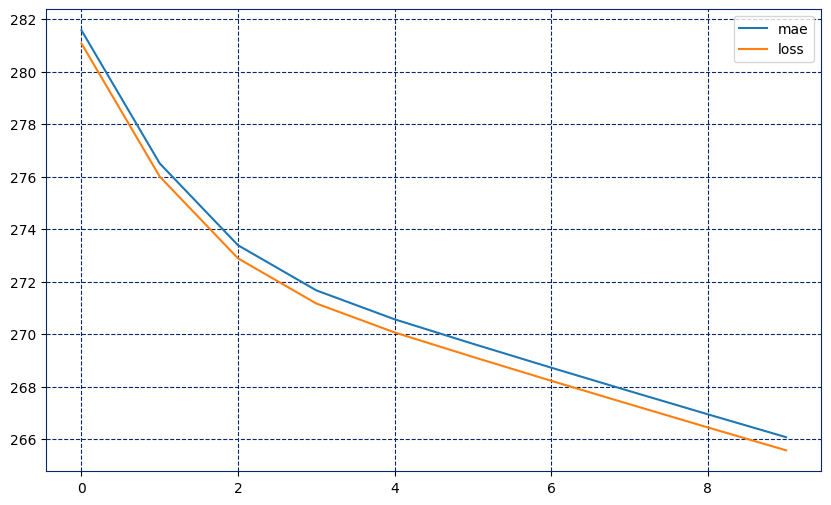

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [140]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<AxesSubplot:>

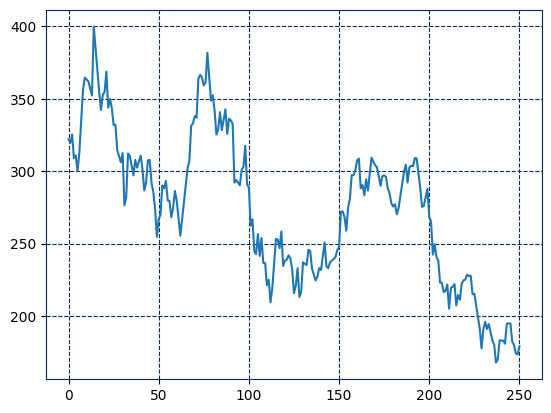

In [141]:
df['Close'].plot()

8/8 [==============================] - 4s 230ms/step


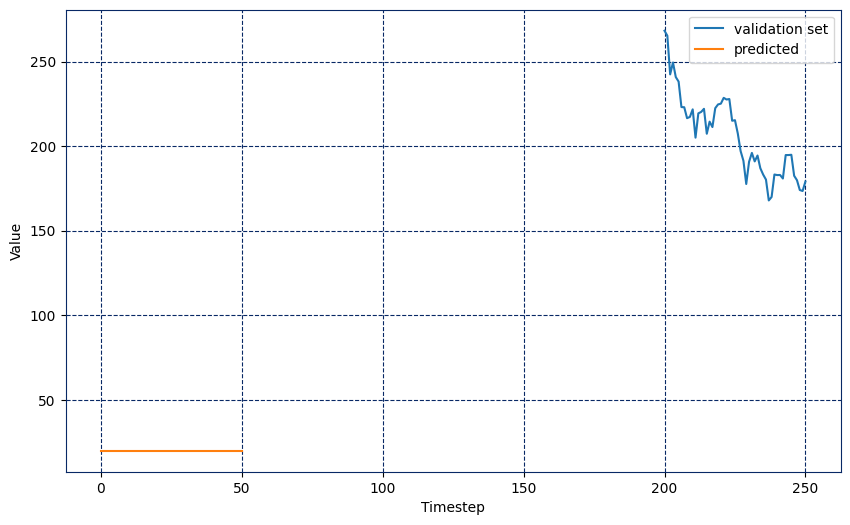

In [142]:
all_forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()
val_forecast = all_forecast[SPLIT_TIME - WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# LSTM training model

In [181]:
import numpy as np
from matplotlib import pyplot
import csv

from keras.layers import Dense, LSTM, Input, Dropout, Embedding, Bidirectional
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [182]:
dataset = []
maxStrokeLen = 0

with open("stock_data.csv") as f:
    reader = csv.reader(f)
    for row in reader:
            dataset.append(row[0].strip())
            
for i in dataset:
    if i:
        if len(i) > maxStrokeLen:
            maxStrokeLen = len(i)
        
maxStrokesCount = len(dataset) - 1
    
print(maxStrokeLen)
print(maxStrokesCount)

154
5791


In [183]:
maxStrokeLen = 200
maxStrokesCount = 6000
maxWordLen = 12

positiveCount = 3685
negativeCount = 2106

tokenizer = Tokenizer(num_words=maxStrokesCount, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(dataset)

dist = list(tokenizer.word_counts.items())


data = tokenizer.texts_to_sequences(dataset)
data_pad = pad_sequences(data, maxlen = maxWordLen)

X = data_pad
Y = np.array([[1,0]]*positiveCount + [[0,1]]*negativeCount)
print(X.shape, Y.shape)

(5792, 12) (5791, 2)


In [184]:
indeces = np.random.choice(X.shape[0]-1, size=X.shape[0]-1, replace=False)
X = X[indeces]
Y = Y[indeces]

In [185]:
model = Sequential()
model.add(Embedding(maxStrokesCount, 128, input_length = maxWordLen))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 128)           768000    
                                                                 
 lstm_2 (LSTM)               (None, 12, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 949,122
Trainable params: 949,122
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

In [187]:
history = model.fit(X, Y, batch_size=32, epochs=10)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

Epoch 1/10
181/181 [==============================] - 5s 14ms/step - loss: 0.6444 - accuracy: 0.6439
Epoch 2/10
181/181 [==============================] - 2s 14ms/step - loss: 0.5217 - accuracy: 0.7652
Epoch 3/10
181/181 [==============================] - 2s 14ms/step - loss: 0.4191 - accuracy: 0.8068
Epoch 4/10
181/181 [==============================] - 2s 14ms/step - loss: 0.3532 - accuracy: 0.8458
Epoch 5/10
181/181 [==============================] - 2s 13ms/step - loss: 0.2998 - accuracy: 0.8734
Epoch 6/10
181/181 [==============================] - 2s 14ms/step - loss: 0.2600 - accuracy: 0.8926
Epoch 7/10
181/181 [==============================] - 2s 14ms/step - loss: 0.2228 - accuracy: 0.9114
Epoch 8/10
181/181 [==============================] - 2s 14ms/step - loss: 0.1959 - accuracy: 0.9176
Epoch 9/10
181/181 [==============================] - 2s 14ms/step - loss: 0.1757 - accuracy: 0.9275
Epoch 10/10
181/181 [==============================] - 2s 14ms/step - loss: 0.1587 - accura

In [37]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [38]:
t = "The oil brent is growing up! Economists predicts plus 5 precent to the cost".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

t1 = "Monday's relative weakness. NYX WIN TIE TAP ICE INT BMC AON C CHK BIIB  ".lower()
data = tokenizer.texts_to_sequences([t1])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

t2 = "URALS brend is going higher and higher! Economysts forecasts a 10 precent growh in a week".lower()
data = tokenizer.texts_to_sequences([t2])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

['the', 'oil', 'is', 'growing', 'up', 'economists', 'predicts', 'plus', '5', 'to', 'the', 'cost']
1/1 [==============================] - 1s 501ms/step
[[3.1899566e-05 9.9996805e-01]]
1
["monday's", 'relative', 'weakness', 'nyx', 'win', 'tie', 'tap', 'ice', 'int', 'bmc', 'aon', 'c', 'chk', 'biib']
1/1 [==============================] - 0s 15ms/step
[[9.999784e-01 2.161980e-05]]
0
['is', 'going', 'higher', 'and', 'higher', 'forecasts', 'a', '10', 'in', 'a', 'week']
1/1 [==============================] - 0s 15ms/step
[[0.17489623 0.82510376]]
1
